# Oil availability prediction model

This model aims at using existing production and reserves data to anticipate oil availability and especially shortage of oil supply until 2100.

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Exploring and cleaning dataset

In [2]:
class dataset:
    df= pd.DataFrame()
    source = 'data/bp-stats-review-2020-consolidated-dataset-panel-format.csv'
    
    def __init__(self):
        self.load_dataset()
        self.cleaning_bp_dataset()
    
    def load_dataset(self):
        self.df = pd.read_csv(self.source)
    
    def set_source(self, path):
        self.source = path
        
    def cleaning_bp_dataset(self):
        # converting production and consommation to volume per year in bbl
        self.df.loc[:,'oilcons_yearlybbl'] = self.df.oilcons_kbd.apply(lambda x: x*361/1000000)
        self.df.loc[:,'oilprod_yearlybbl'] = self.df.oilprod_kbd.apply(lambda x: x*361/1000000)
        # restraining dataset only to useful feature for oil assertion
        self.df = self.df[['Country', 'Year', 'pop', 'ISO3166_alpha3', 'Region',
       'SubRegion', 'OPEC', 'EU', 'OECD', 'CIS','oilprod_yearlybbl','oilcons_yearlybbl', 'oilreserves_bbl']]
        # remove all total counts from the data
        self.df = self.df[~self.df.Country.isin(['Total Africa',
       'Total Asia Pacific', 'Total CIS', 'Total Central America',
       'Total Eastern Africa', 'Total Europe', 'Total European Union',
       'Total Middle Africa', 'Total Middle East', 'Total Non-OECD',
       'Total North America', 'Total OECD', 'Total S. & Cent. America',
       'Total Western Africa', 'Total World'])]
        # fill the missing reserves by backfill method
        self.df.oilreserves_bbl = self.df.oilreserves_bbl.fillna(method='bfill')
        # calculating the cumulated production of oil per country
        self.df.loc[:,'cumulated_prod_bbl'] = self.df.groupby(['Country'])['oilprod_yearlybbl'].cumsum()
        # calculating a corrected reserve by country by removing the production which seems to have been eluded (ex. UAE)
        self.df['reserves_corr'] = self.df['oilreserves_bbl'] - self.df['cumulated_prod_bbl']
        self.df['reserves_corr'] = self.df['reserves_corr'].apply(lambda x:x if x>=0 else 0)
    

In [3]:
dt = dataset()

*__Previous exploration replaced by dataset object__*

________________________________

In [4]:
# getting dataset
df = pd.read_csv('data/bp-stats-review-2020-consolidated-dataset-panel-format.csv')

In [5]:
# converting production and consommation to volume per year in bbl
df.loc[:,'oilcons_yearlybbl'] = df.oilcons_kbd.apply(lambda x: x*361/1000000)
df.loc[:,'oilprod_yearlybbl'] = df.oilprod_kbd.apply(lambda x: x*361/1000000)

In [6]:
# restraining dataset only to useful feature for oil assertion
df = df[['Country', 'Year', 'pop', 'ISO3166_alpha3', 'Region',
       'SubRegion', 'OPEC', 'EU', 'OECD', 'CIS','oilprod_yearlybbl','oilcons_yearlybbl', 'oilreserves_bbl']]

In [7]:
# remove all total counts from the data
df = df[~df.Country.isin(['Total Africa',
       'Total Asia Pacific', 'Total CIS', 'Total Central America',
       'Total Eastern Africa', 'Total Europe', 'Total European Union',
       'Total Middle Africa', 'Total Middle East', 'Total Non-OECD',
       'Total North America', 'Total OECD', 'Total S. & Cent. America',
       'Total Western Africa', 'Total World'])]

In [8]:
# fill the missing reserves by backfill method
df.oilreserves_bbl = df.oilreserves_bbl.fillna(method='bfill')

In [9]:
# calculating the cumulated production of oil per country
df.loc[:,'cumulated_prod_bbl'] = df.groupby(['Country'])['oilprod_yearlybbl'].cumsum()

In [10]:
# calculating a corrected reserve by country by removing the production which seems to have been eluded (ex. UAE)
df['reserves_corr'] = df['oilreserves_bbl'] - df['cumulated_prod_bbl']
df['reserves_corr'] = df['reserves_corr'].apply(lambda x:x if x>=0 else 0)

In [11]:
# cheking that df and df.dt are the same need to count that the na are seen as false for comparison and ensure we are just finding it
df.isna().sum().sum() == (df !=dt.df).sum().sum()

True

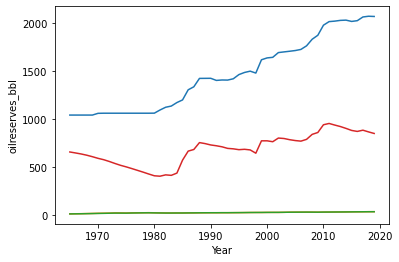

In [12]:
# plotting constructed variable vs original
data = df.groupby('Year').sum()
sns.lineplot(data = data, x = 'Year', y= 'oilreserves_bbl');
sns.lineplot(data = data, x = 'Year', y= 'oilprod_yearlybbl');
sns.lineplot(data = data, x = 'Year', y= 'oilcons_yearlybbl');
sns.lineplot(data = data, x = 'Year', y= 'reserves_corr');

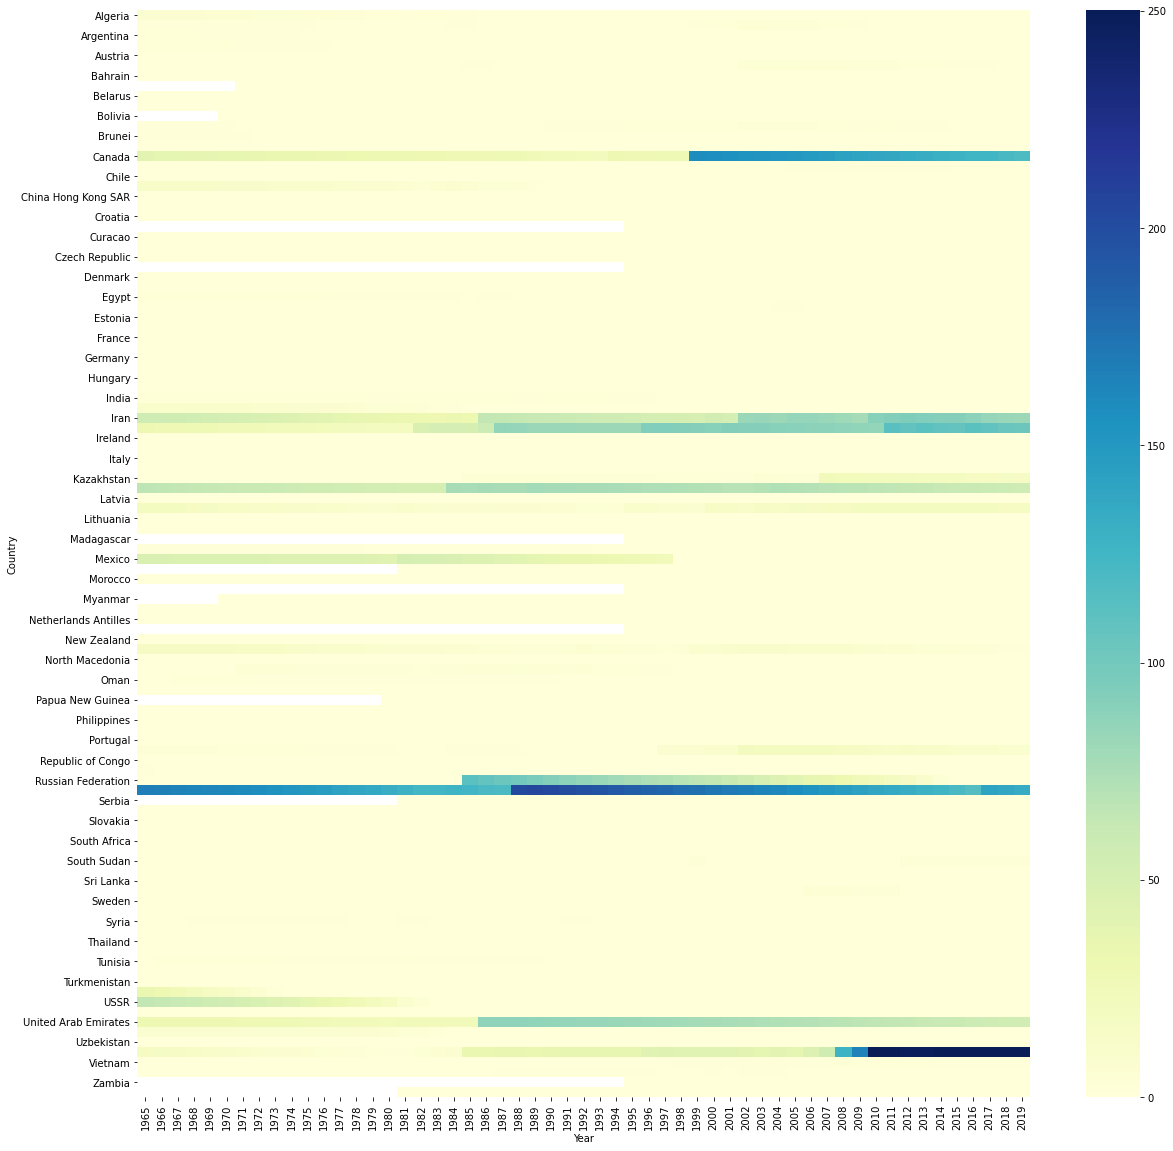

In [13]:
# plotting as heatmap to see the granularity at country level
plt.figure(figsize = (20,20));
sns.heatmap(df.pivot('Country','Year', 'reserves_corr'), cmap="YlGnBu");

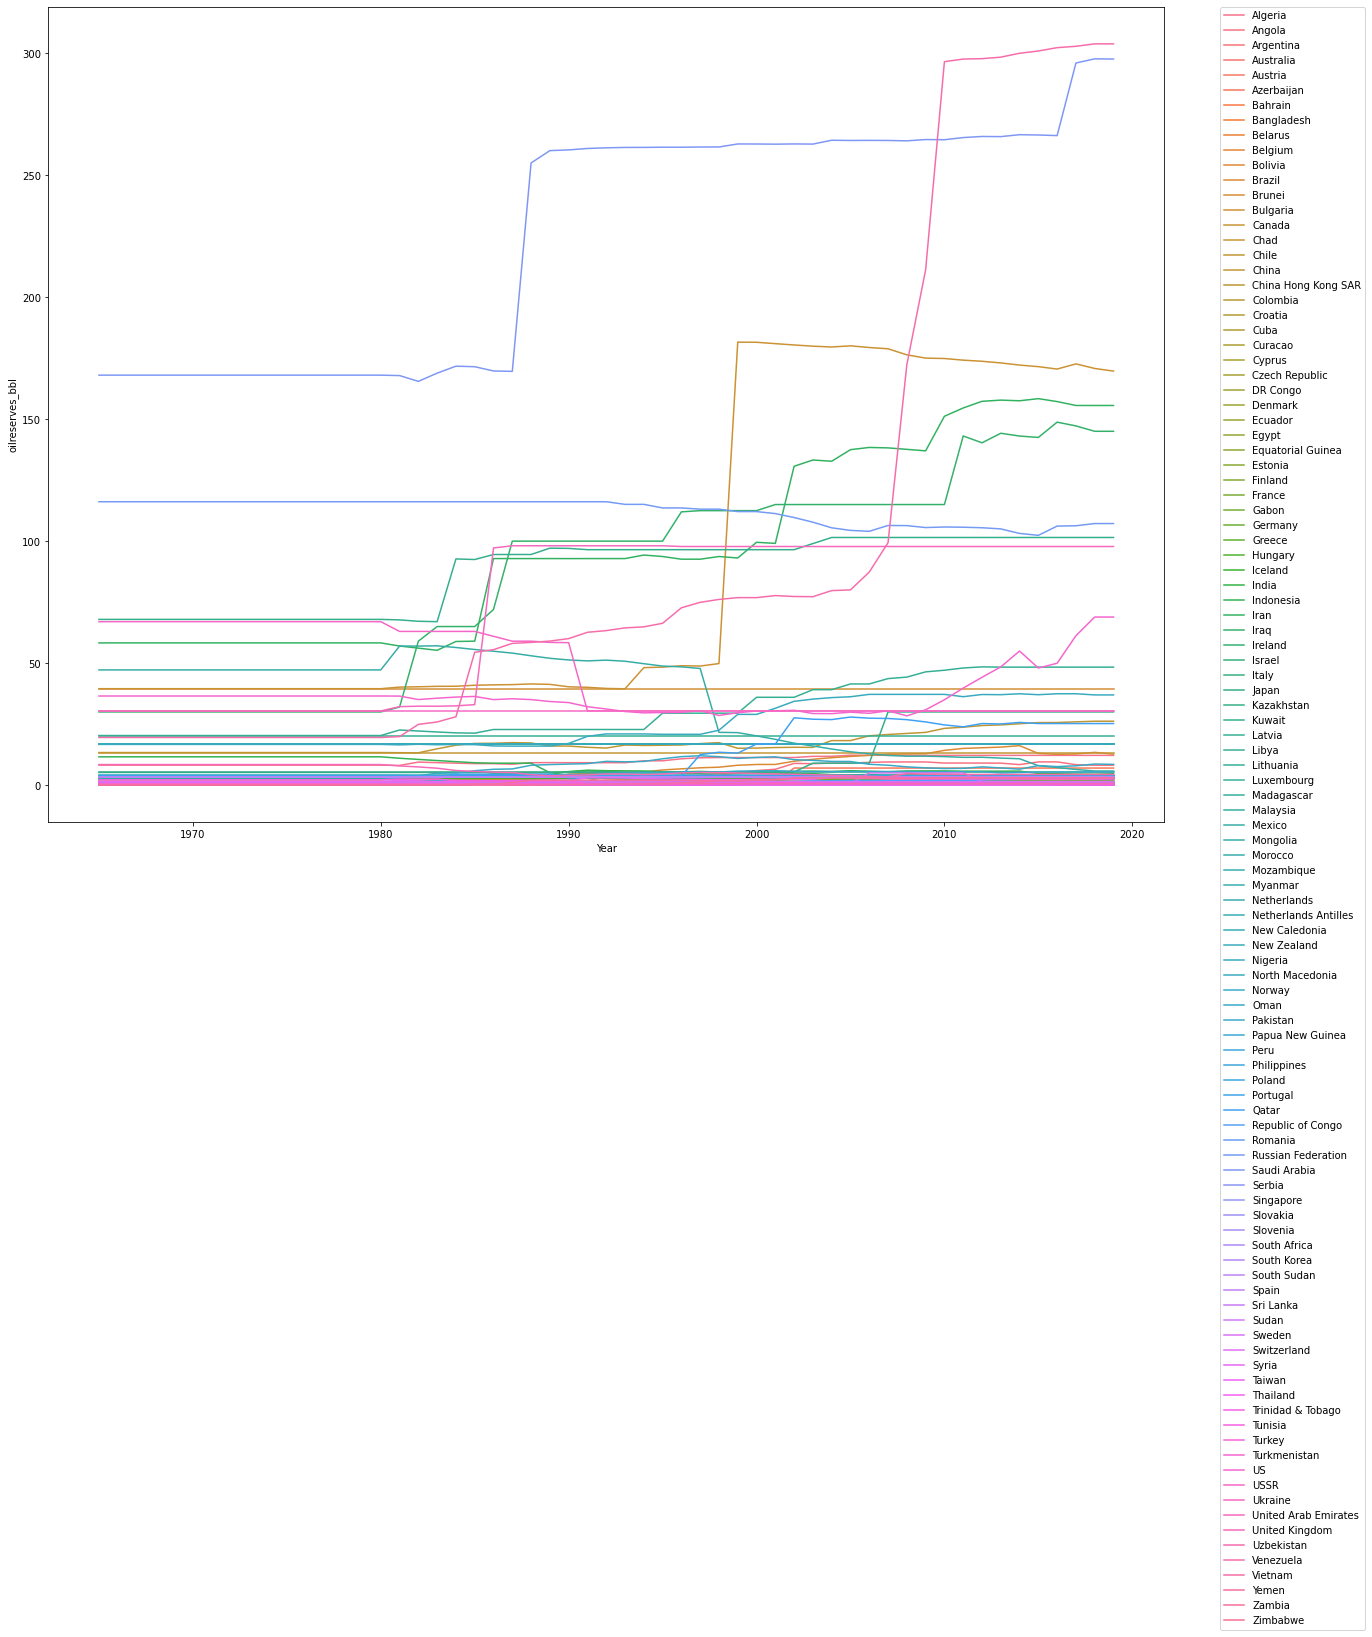

In [14]:
# other plot of the reserves by country
plt.figure(figsize=(20,15));
sns.lineplot(x= 'Year', y ='oilreserves_bbl', data = df, hue = 'Country');
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

We observe that the reserve data are maybe not so accurate because while Canada seems with a logical trend all of the other seems indeed not to account for the extraction. By correcting the reserve as we did, we might have changed to the correctd trend but amplified some reserves decrease where it was already accounted for. We will check at the end but according to worldometer we should be around 2047 for the end of world resources but it might be itself also wrong.

____

## Create reserve regression model object

In [15]:
# import required classes
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
set_config(display='diagram')

In [20]:
class reserves_model:
    
    df = pd.DataFrame()
    pred_end = 2300
    years_2100 = np.arange(1965,pred_end + 1 ,1)
    lasso = make_pipeline(StandardScaler(),Lasso(tol = .0001, alpha = .01))
    elNet = make_pipeline(StandardScaler(), ElasticNet(l1_ratio=0.7))
    linreg = make_pipeline(StandardScaler(), LinearRegression())
    svr = make_pipeline(StandardScaler(),SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,coef0=1))
    rbf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf', C=100, gamma=0.1, epsilon=.1))
    model = lasso
    preds = dict()
    models = ['lasso','elasticnet','linearregression','svr', 'rbf']
    end_of_reserves = []
    total_prod_2020 = pd.DataFrame()
    production_proportions_2019 = []
    eor = pd.DataFrame()
    world_limits = dict()
    
    def __init__(self, data):
        for i in self.models:
            preds[i] = pd.DataFrame(years_2100, columns = ['Year'])
        # run over all models and all countries
        for i in self.df.Country.unique():
            for j in self.models:
                self.reg_country(country = i, model_name = j)
        # correcting predictions to avoid negative values
        for i in self.models:
            self.preds[i] = self.preds[i].applymap(lambda x:x if x >=0 else 0)
            # calculating at world level
        for i in self.models:
            self.preds[i]['World'] = self.preds[i][self.df.Country.unique()].sum(axis = 1)
            
        self.total_prod_2020 = self.df.query('Year == 2019').oilprod_yearlybbl.sum()
        
        for country in self.df.Country.unique():
            production_proportions_2019 = []
            prod = dict()
            prod['Country'] = country
            prod['Proportion'] = self.df.query('Country == @country & Year ==2019').oilprod_yearlybbl.sum()/total_prod_2020
            prod['Year'] = 2019
            production_proportions_2019.append(prod)
        self.production_proportions_2019 = pd.DataFrame(production_proportions_2019)
#         already choosing lasso as baseline model
        self.find_country_eor()
        end_of_reserves(model_name = 'lasso')
        
        for i in self.models:
            share_prod(i)
            self.preds[i]['World'] = self.preds[i][self.df.Country.unique()].sum(axis = 1)

        self.world_limits = {'lasso': reserve_limit('World'), 'svr': reserve_limit('World', 'svr'), 'rbf': reserve_limit('World', 'rbf')} 
    
    # create funciton to perform regression on a country
    def reg_country(self, country, model_name = 'lasso', remove_outliers = False, truncated_2000 = False, max_truncated = True):
        df = self.df
        model = self.model
        dfc = df.query("Country == @country")
    #     temporary correction for south sudan data - positive regression
        if country == 'South Sudan':
            dfc = dfc.query('Year >= 2015')
            remove_outliers = False
            truncated_2000 = False
            max_truncated = False
        else:
            pass
        if max_truncated:
            start_year = df.query('Country == @country')[df.query('Country == @country').reserves_corr == df.query('Country == @country').reserves_corr.max()].Year.values[0]
            dfc = dfc.query('Year >= @start_year')
        else:
            pass
        if truncated_2000:
            dfc = dfc.query('Year >= 2000')
        else:
            pass
        if remove_outliers:
            dfc = dfc[(dfc['reserves_corr'] >= dfc['reserves_corr'].mean() - dfc['reserves_corr'].std()) & (dfc['reserves_corr'] <= dfc['reserves_corr'].mean() + dfc['reserves_corr'].std())]
        else:
            pass
        X_train = dfc.Year.values.reshape(-1,1)
        Y_train = dfc.reserves_corr.values
        X = df.loc[df['Country'] == country].Year.unique().reshape(-1,1)
        model.fit(X_train,Y_train)
        global years_2100
        df.loc[df['Country'] == country,model_name] = model.predict(X)
        preds[model_name][country] = model.predict(years_2100.reshape(-1,1))
    #     adding scores and coefs
        if model_name in ['lasso','linearregression','elasticnet']:
            sc[model_name].loc[country,'coef'] = model.named_steps[model_name].coef_[0]
            sc[model_name].loc[country,'intercept'] = model.named_steps[model_name].intercept_
            sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))
        elif model_name == 'svr':
            sc[model_name].loc[country,'coef'] = model.named_steps[model_name].dual_coef_
            sc[model_name].loc[country,'intercept'] = model.named_steps[model_name].intercept_
            sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))
        elif model_name == 'rbf':
    #         sc[model_name].loc[country,'coef'] = model.named_steps['svr'].dual_coef_
    #         sc[model_name].loc[country,'intercept'] = model.named_steps['svr'].intercept_
            sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))

        # for polynomial regression take the hypotesis that reserves never goes up after reaching 0
    def end_of_reserves(self, model_name = 'lasso'):
        '''
        applicabel for svr and rbf
        '''
        end_of_reserves = []
        for c in self.df.Country.unique():
            end_reserve = dict()
            end_reserve['country'] = c
            end_reserve['min_res'] = self.preds[model_name][c].min()
            if end_reserve['min_res'] <= 0:
                end_reserve['end_year'] = self.preds[model_name][self.preds[model_name][c]<=0].Year.min()
            else:
                end_reserve['end_year'] = self.pred_end + 1
            end_reserve['min_res'] = self.preds[model_name][c].min()
            if end_reserve['min_res'] > 0:
                 end_reserve['min_res_year'] = self.pred_end + 1
            else:
                end_reserve['min_res_year'] = self.preds[model_name][self.preds[model_name][c] == self.preds[model_name][c].min()].Year.values[0]
            self.preds[model_name].loc[self.preds[model_name]['Year']>= end_reserve['end_year'],c] = 0
            self.preds[model_name].loc[self.preds[model_name]['Year']>= end_reserve['min_res_year'],c] = end_reserve['min_res']
            end_of_reserves.append(end_reserve)
        self.eor = pd.DataFrame(end_of_reserves)

    # create a plot of all regressions
    def plot_reg(self,country, model_name='lasso'):
        plt.title(f'{country}')
        data = self.df.groupby(['Country','Year']).sum().loc[country].reset_index()
        sns.lineplot(x = 'Year', y= 'reserves_corr', data = data);
    #     sns.lineplot(x = 'Year', y= model_name, data= data);
        plt.axhline(0, color = 'orange');
        sns.lineplot(x = 'Year', y= country, data = self.preds[model_name], color = 'green');
    #     sns.lineplot(x = 'Year', y= country, data = preds_svr);
        plt.show()

    def world_reserves(self, model_name= 'lasso'):
        sns.lineplot(x = 'Year', y = 'World', data = self.preds[model_name]);
        sns.lineplot(x = 'Year', y = 'oilcons_yearlybbl', data = self.df.groupby(['Year']).sum());
        plt.show()
        # other plot of the reserves by country
        plt.figure(figsize=(20,30));
        sns.lineplot(data = self.preds[model_name].set_index('Year'));
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
        plt.show()

    # year in which reserves will be consumed entirely
    def reserve_limit(self,country, model = 'lasso'):
        return self.preds[model][self.preds[model][country]<=0].Year.min()


    # function to set a number to 0 when negative for reserve consistency
    def neg_to_0(i):
        if i > 0:
            return i
        else:
            return 0

    def share_prod(self, model):
        # number of countries who still have predicted reserves in 2019 for the selected model (svr to test)
        nb_producers_2019 = self.eor.query('min_res_year > 2019').shape[0]
        add = 0
        # redistribute in the first year all the remaining reserves from country bending before 2019
        corr = 0
        corr_i = 0
        producers = self.eor.query('min_res_year > 2019').country.unique().tolist()
        for i in range(2020,self.pred_end + 1,1):
            if self.eor.query('min_res_year == @i').shape[0] > 0:
        #         remove these countries from the list
                nb_producers_2019 -= len(self.eor.query('min_res_year == @i').country.values)
                for j in self.eor.query('min_res_year == @i').country.values:
                    producers.remove(j)
          # total of oil production to reassign to remaining countries
                add = add + self.production_proportions_2019[self.production_proportions_2019['Country'].isin(self.eor.query('min_res_year == @i').country.values)].Proportion.sum()*self.total_prod_2020
           # new correction
                if nb_producers_2019 == 0:
                    continue
                corr_i = add / nb_producers_2019
         # add here the loop to change all preds in df or add a correction or copy existing value to uncorrected
            self.preds[model].loc[self.preds[model]['Year'] == i,producers] = self.preds[model].loc[self.preds[model]['Year'] == i,producers].applymap(lambda x: x - corr)
            self.preds[model].loc[self.preds[model]['Year'] == i,producers] = self.preds[model].loc[self.preds[model]['Year'] == i,producers].applymap(self.neg_to_0)
            corr += corr_i

    def find_country_eor(self, model_name = 'lasso'):
    # determining end of reserves by country for the predictions
        pred = self.preds[model_name]
        pred_reserves_end = pred.set_index('Year').idxmin().reset_index()
        pred_reserves_end.columns =['Country','Year']

        # recreate series of point corrresponding to the world reserve at the moment a country comes out of reserve
        shortage_world_reserves = pred_reserves_end.Year.apply(lambda x: pred[pred['Year'] == x].World.values[0])
        plt.figure(figsize = (15,30))
        sns.lineplot(x = 'Year', y='World', data = pred);
        plt.scatter(x = pred_reserves_end.Year, y= shortage_world_reserves, color = 'red');
        # plot country name next to each point
        for i, txt in enumerate(pred_reserves_end.Country):
            plt.annotate(txt, (pred_reserves_end.Year[i]+1, shortage_world_reserves[i]+1));
        plt.hlines(xmin = 1990, xmax = pred_end + 1 , y=0, color = 'red');
        plt.show()

_____

In [21]:
pred_end = 2300

In [22]:
#  pipeline using lasso regression
lasso = make_pipeline(StandardScaler(),Lasso(tol = .0001, 
alpha = .01))
lasso

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01))])

In [23]:
#  pipeline using elasticNet regression
elNet = make_pipeline(StandardScaler(), ElasticNet(l1_ratio=0.7))
elNet

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(l1_ratio=0.7))])

In [24]:
#  pipeline using linear regression
linreg = make_pipeline(StandardScaler(), LinearRegression())
linreg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [25]:
#  pipeline using support vector machine regression
svr = make_pipeline(StandardScaler(),SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,
               coef0=1))
svr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(C=100, coef0=1, degree=2, gamma='auto', kernel='poly'))])

In [26]:
# pipeline using svr with rdf kernel to test if more efficent removing noise to extract trend
rbf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf', C=100, gamma=0.1, epsilon=.1))
rbf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, gamma=0.1))])

In [27]:
#  creating y sets for predictions and r2score calculation
years_2100 = np.arange(1965,pred_end + 1 ,1)

___

In [28]:
# list of available models
models = ['lasso','elasticnet','linearregression','svr', 'rbf']

In [29]:
# creating a dataframe to host 2100 predictions
preds = dict()
for i in models:
    preds[i] = pd.DataFrame(years_2100, columns = ['Year'])

In [30]:
# creating a dataframe to host model prediction scores
sc = dict()
for i in models:
    sc[i] = pd.DataFrame(index = df.Country.unique(), columns = ['coef','intercept','r2'])

In [31]:
# create funciton to perform regression on a country
def reg_country(country, model_name = 'lasso', remove_outliers = False, truncated_2000 = False, max_truncated = True):
    global lasso
    global elNet
    global svr
    global linreg
    if model_name == 'lasso':
        model = lasso
    elif model_name == 'elasticnet':
        model = elNet
    elif model_name == 'linearregression':
        model = linreg
    elif model_name == 'svr':
        model = svr
    elif model_name == 'rbf':
        model = rbf
    else:
        model = lasso
        print('Model name not found, initialized with default model Lasso')
        
    dfc = df.query("Country == @country")
#     temporary correction for south sudan data - positive regression
    if country == 'South Sudan':
        dfc = dfc.query('Year >= 2015')
        remove_outliers = False
        truncated_2000 = False
        max_truncated = False
    else:
        pass
    if max_truncated:
        start_year = df.query('Country == @country')[df.query('Country == @country').reserves_corr == df.query('Country == @country').reserves_corr.max()].Year.values[0]
        dfc = dfc.query('Year >= @start_year')
    else:
        pass
    if truncated_2000:
        dfc = dfc.query('Year >= 2000')
    else:
        pass
    if remove_outliers:
        dfc = dfc[(dfc['reserves_corr'] >= dfc['reserves_corr'].mean() - dfc['reserves_corr'].std()) & (dfc['reserves_corr'] <= dfc['reserves_corr'].mean() + dfc['reserves_corr'].std())]
    else:
        pass
    X_train = dfc.Year.values.reshape(-1,1)
    Y_train = dfc.reserves_corr.values
    X = df.loc[df['Country'] == country].Year.unique().reshape(-1,1)
    model.fit(X_train,Y_train)
    global years_2100
    df.loc[df['Country'] == country,model_name] = model.predict(X)
    preds[model_name][country] = model.predict(years_2100.reshape(-1,1))
#     adding scores and coefs
    if model_name in ['lasso','linearregression','elasticnet']:
        sc[model_name].loc[country,'coef'] = model.named_steps[model_name].coef_[0]
        sc[model_name].loc[country,'intercept'] = model.named_steps[model_name].intercept_
        sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))
    elif model_name == 'svr':
        sc[model_name].loc[country,'coef'] = model.named_steps[model_name].dual_coef_
        sc[model_name].loc[country,'intercept'] = model.named_steps[model_name].intercept_
        sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))
    elif model_name == 'rbf':
#         sc[model_name].loc[country,'coef'] = model.named_steps['svr'].dual_coef_
#         sc[model_name].loc[country,'intercept'] = model.named_steps['svr'].intercept_
        sc[model_name].loc[country,'r2'] = r2_score(Y_train, model.predict(X_train))

In [32]:
# hide warning
import warnings
warnings.filterwarnings('ignore')

# run over all moedls and all countries
for i in df.Country.unique():
    for j in models:
        reg_country(country = i, model_name = j)

In [33]:
# correcting predictions to avoid negative values
for i in models:
    preds[i] = preds[i].applymap(lambda x:x if x >=0 else 0)

In [34]:
# for polynomial regression take the hypotesis that reserves never goes up after reaching 0
def end_of_reserves(model_name = 'svr'):
    '''
    applicabel for svr and rbf
    '''
    end_of_reserves = []
    for c in df.Country.unique():
        end_reserve = dict()
        end_reserve['country'] = c
        end_reserve['min_res'] = preds[model_name][c].min()
        if end_reserve['min_res'] <= 0:
            end_reserve['end_year'] = preds[model_name][preds[model_name][c]<=0].Year.min()
        else:
            end_reserve['end_year'] = pred_end + 1
        end_reserve['min_res'] = preds[model_name][c].min()
        if end_reserve['min_res'] > 0:
             end_reserve['min_res_year'] = pred_end + 1
        else:
            end_reserve['min_res_year'] = preds[model_name][preds[model_name][c] == preds[model_name][c].min()].Year.values[0]
        preds[model_name].loc[preds[model_name]['Year']>= end_reserve['end_year'],c] = 0
        preds[model_name].loc[preds[model_name]['Year']>= end_reserve['min_res_year'],c] = end_reserve['min_res']
        end_of_reserves.append(end_reserve)
    return pd.DataFrame(end_of_reserves)

In [35]:
# calculating at world level
for i in models:
    preds[i]['World'] = preds[i][df.Country.unique()].sum(axis = 1)

In [36]:
# create a plot of all regressions
def plot_reg(country, model_name='lasso'):
    plt.title(f'{country}')
    data = df.groupby(['Country','Year']).sum().loc[country].reset_index()
    sns.lineplot(x = 'Year', y= 'reserves_corr', data = data);
#     sns.lineplot(x = 'Year', y= model_name, data= data);
    plt.axhline(0, color = 'orange');
    sns.lineplot(x = 'Year', y= country, data = preds[model_name], color = 'green');
#     sns.lineplot(x = 'Year', y= country, data = preds_svr);
    plt.show()

In [37]:
def world_reserves(model_name= 'lasso'):
    sns.lineplot(x = 'Year', y = 'World', data = preds[model_name]);
    sns.lineplot(x = 'Year', y = 'oilcons_yearlybbl', data = df.groupby(['Year']).sum());
    plt.show()
    # other plot of the reserves by country
    plt.figure(figsize=(20,30));
    sns.lineplot(data = preds[model_name].set_index('Year'));
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
    plt.show()

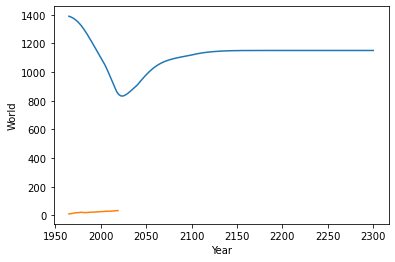

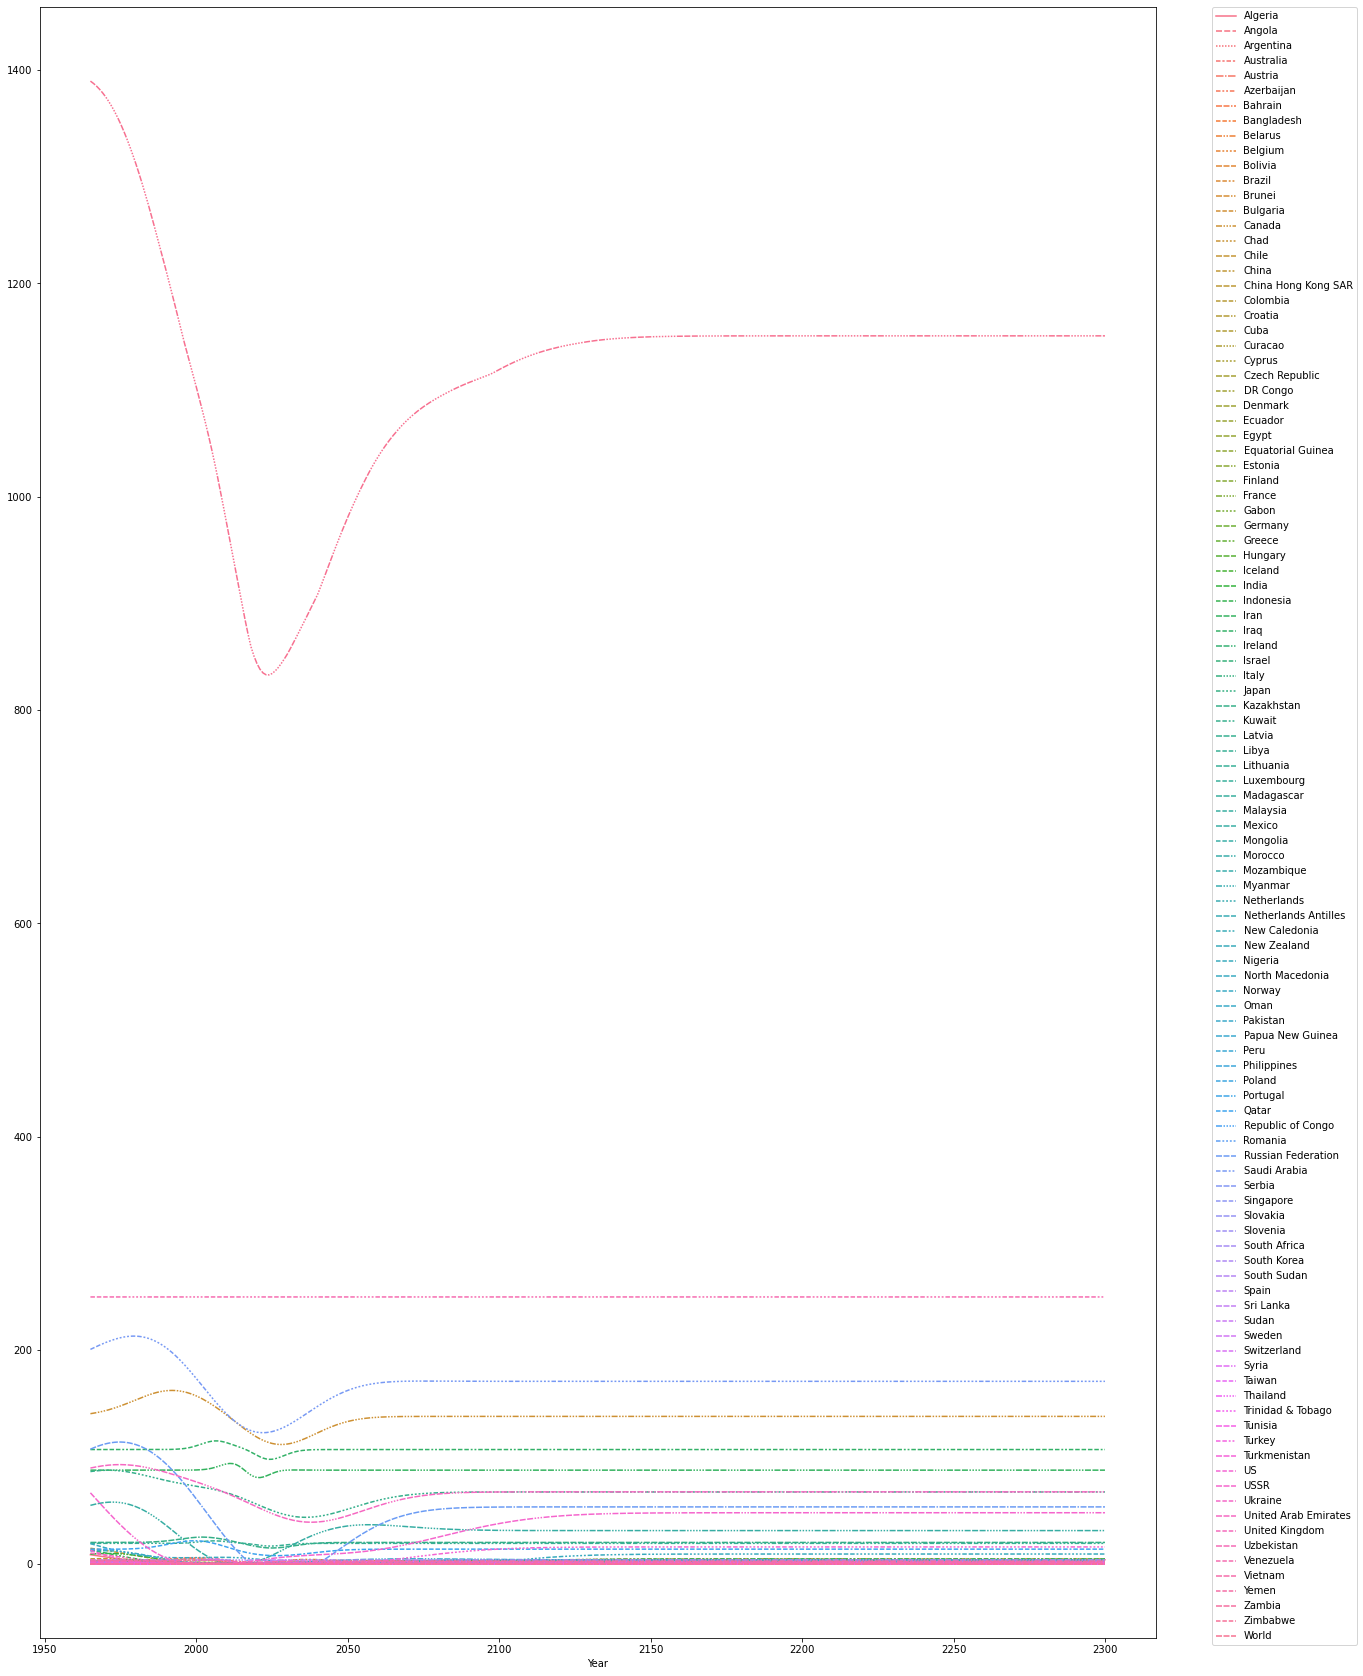

In [38]:
world_reserves(model_name = 'rbf')

In [39]:
def pos_reserve_evolution(model = 'lasso'):
    if model == 'svr':
        print('not applicable for this model')
        return None
    if len(sc[model].query('coef > 0').index) == 0:
            print('no regression with positive trend')
    for i in sc[model].query('coef > 0').index:
        plot_reg(i)

In [40]:
def pos_reserves2100(model = 'lasso'):
# check the country that still have reserves in 2100
    pos_reserves2100 = preds[model].query('Year == @pred_end')[preds[model].columns[~preds[model].query('Year == @pred_end')[preds[model]> 0].isnull().all()]].set_index('Year')
    # visualizing all country for which remains a reserve in 2100
    for i in pos_reserves2100:
        try:
            plot_reg(i)
        except KeyError:
            sns.lineplot(x = 'Year', y = i, data = preds[model])
            plt.show()
    return pos_reserves2100

In [41]:
# year in which reserves will be consumed entirely
def reserve_limit(country, model = 'lasso'):
    return preds[model][preds[model][country]<=0].Year.min()

In [42]:
reserve_limit('World'), reserve_limit('World', 'svr'), reserve_limit('World', 'rbf')

(nan, nan, nan)

Defining a function that help to calculate the extraction by country accounting for the time reserves end are reached by country:

- calculate total prod in 2019
- calculate proportion of each country producing it
- apply a correction to each calculated prediction by removing the percentage of extrapolated world production share of the country reaching reserves end splited equally on all countries

In [43]:
total_prod_2020 = df.query('Year == 2019').oilprod_yearlybbl.sum()

In [44]:
production_proportions_2019 = []
for country in df.Country.unique():
    prod = dict()
    prod['Country'] = country
    prod['Proportion'] = df.query('Country == @country & Year ==2019').oilprod_yearlybbl.sum()/total_prod_2020
    prod['Year'] = 2019
    production_proportions_2019.append(prod)
production_proportions_2019 = pd.DataFrame(production_proportions_2019)    

In [45]:
production_proportions_2019

,Country,Proportion,Year
0,Algeria,0.015816,2019
1,Angola,0.015081,2019
2,Argentina,0.006602,2019
3,Australia,0.005219,2019
4,Austria,0.000000,2019
...,...,...,...
103,Venezuela,0.009771,2019
104,Vietnam,0.002516,2019
105,Yemen,0.001039,2019
106,Zambia,0.000000,2019


In [46]:
eor = end_of_reserves(model_name = 'svr')

In [47]:
# function to set a number to 0 when negative for reserve consistency
def neg_to_0(i):
    if i > 0:
        return i
    else:
        return 0

In [48]:
def share_prod(model):
    # number of countries who still have predicted reserves in 2019 for the selected model (svr to test)
    nb_producers_2019 = eor.query('min_res_year > 2019').shape[0]
    add = 0
    # redistribute in the first year all the remaining reserves from country bending before 2019
    corr = 0
    corr_i = 0
    producers = eor.query('min_res_year > 2019').country.unique().tolist()
    # print(producers)
    for i in range(2020,pred_end + 1,1):
#         print(corr)
        if eor.query('min_res_year == @i').shape[0] > 0:
#             print(i, eor.query('min_res_year == @i').country.values,production_proportions_2019[production_proportions_2019['Country'].isin(eor.query('min_res_year == @i').country.values)].Proportion.sum()*total_prod_2020)
    #         remove these countries from the list
            nb_producers_2019 -= len(eor.query('min_res_year == @i').country.values)
            for j in eor.query('min_res_year == @i').country.values:
    #             preds['svr'].loc[preds['svr']['Year'] == i,j] = 0
                producers.remove(j)
#             print('producers:\t',nb_producers_2019, producers)
    # total of oil production to reassign to remaining countries
            add = add + production_proportions_2019[production_proportions_2019['Country'].isin(eor.query('min_res_year == @i').country.values)].Proportion.sum()*total_prod_2020
#             print(i, 'prod to share:\t',add)
    # new correction
            if nb_producers_2019 == 0:
                continue
            corr_i = add / nb_producers_2019
#             print(i, 'correction in reserves for each remaining country to extract for this year year:\t',corr)
    # add here the loop to change all preds in df or add a correction or copy existing value to uncorrected
#         print(f'{i} before')
#         display(preds[model].loc[preds[model]['Year'] == i,producers])
        preds[model].loc[preds[model]['Year'] == i,producers] = preds[model].loc[preds[model]['Year'] == i,producers].applymap(lambda x: x - corr)
#         print(corr)
#         print('after')
#         display(preds[model].loc[preds[model]['Year'] == i,producers])
        preds[model].loc[preds[model]['Year'] == i,producers] = preds[model].loc[preds[model]['Year'] == i,producers].applymap(neg_to_0)
        corr += corr_i

    # function to re-evaluate end of resource in remaining countries or change to check each year in df prediction the number of countries with reserves and count how many are being under 0 after current removal of production

    # calculating at world level

In [49]:
for i in models:
    share_prod(i)
    preds[i]['World'] = preds[i][df.Country.unique()].sum(axis = 1)

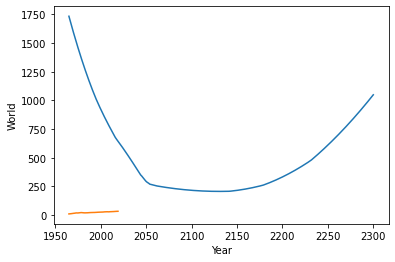

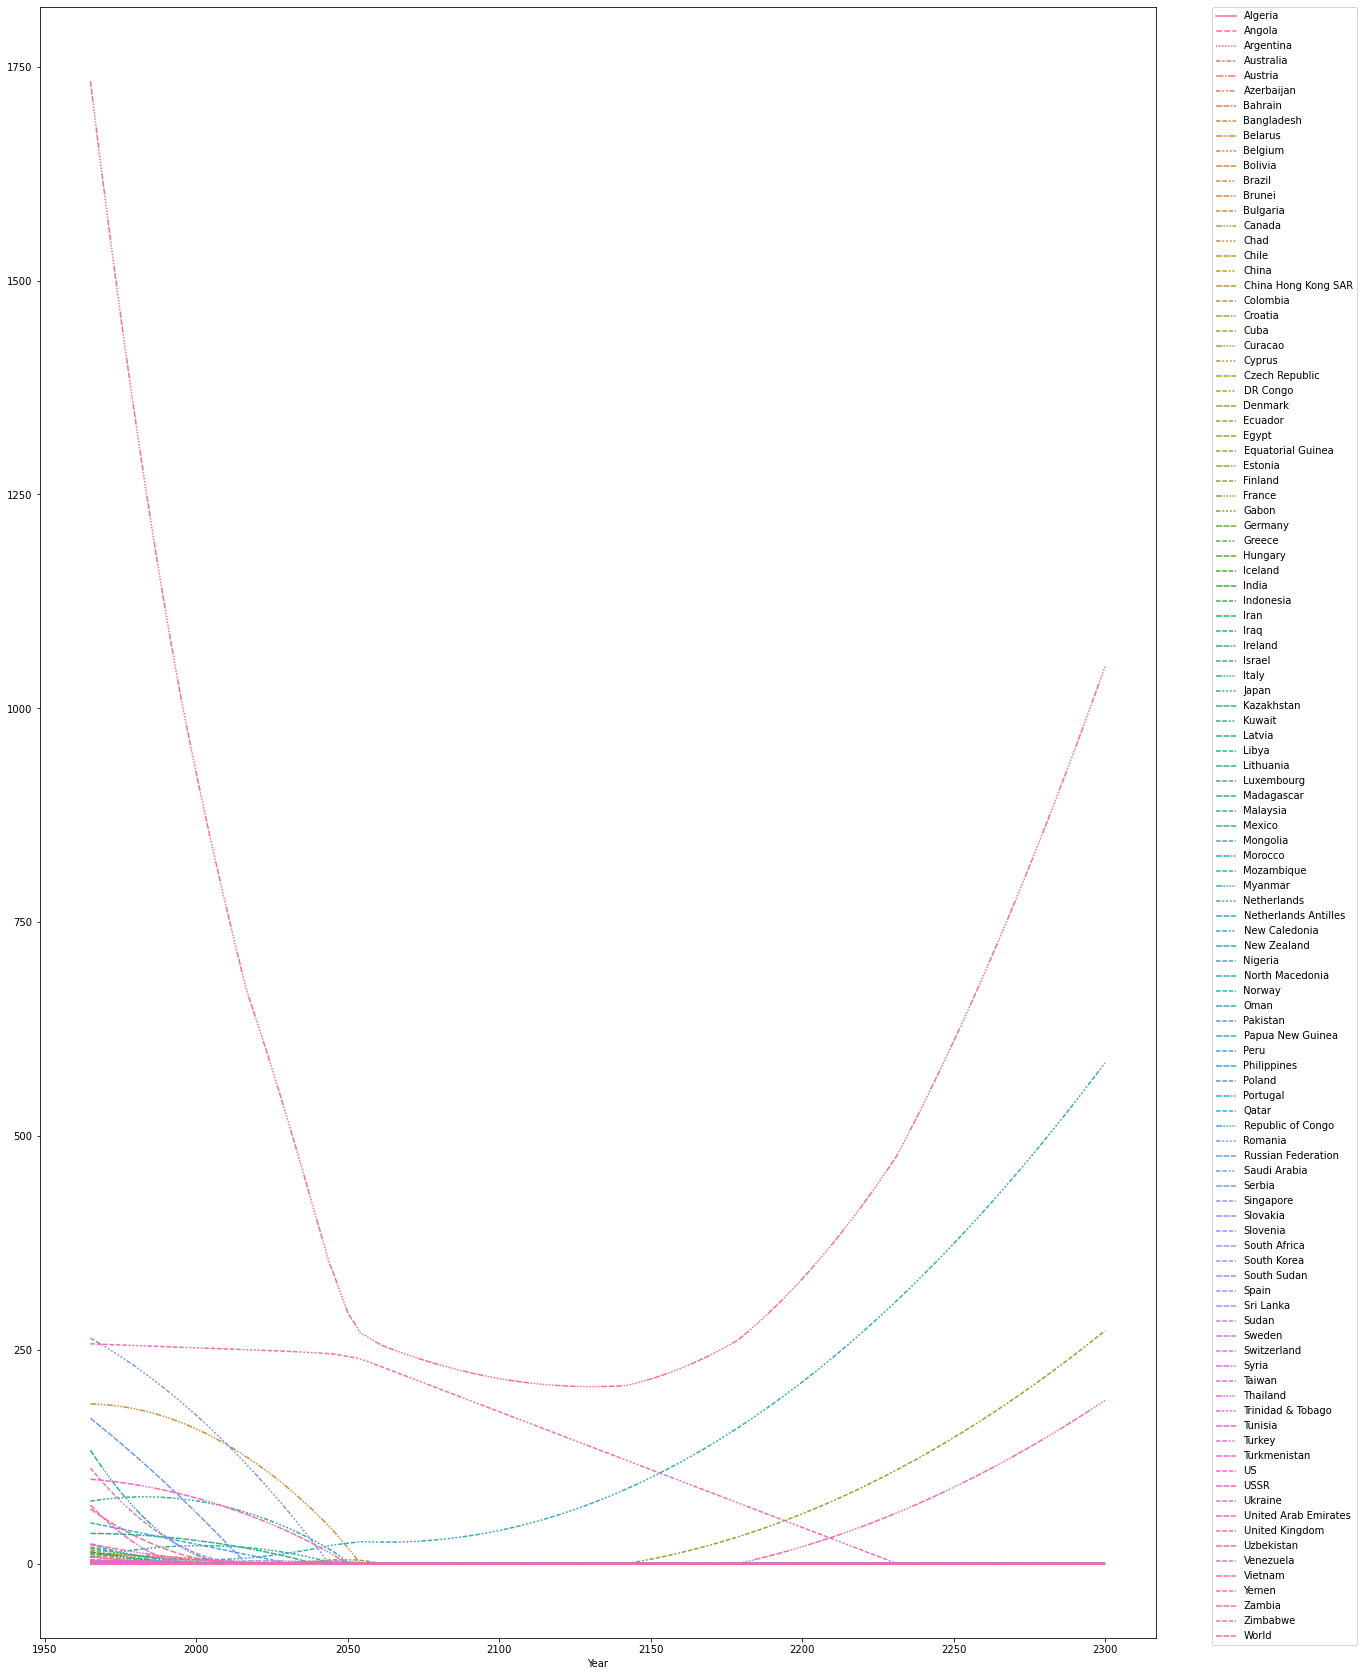

In [50]:
world_reserves(model_name = 'svr')

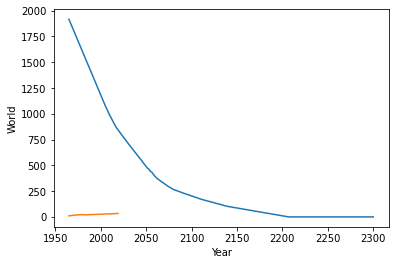

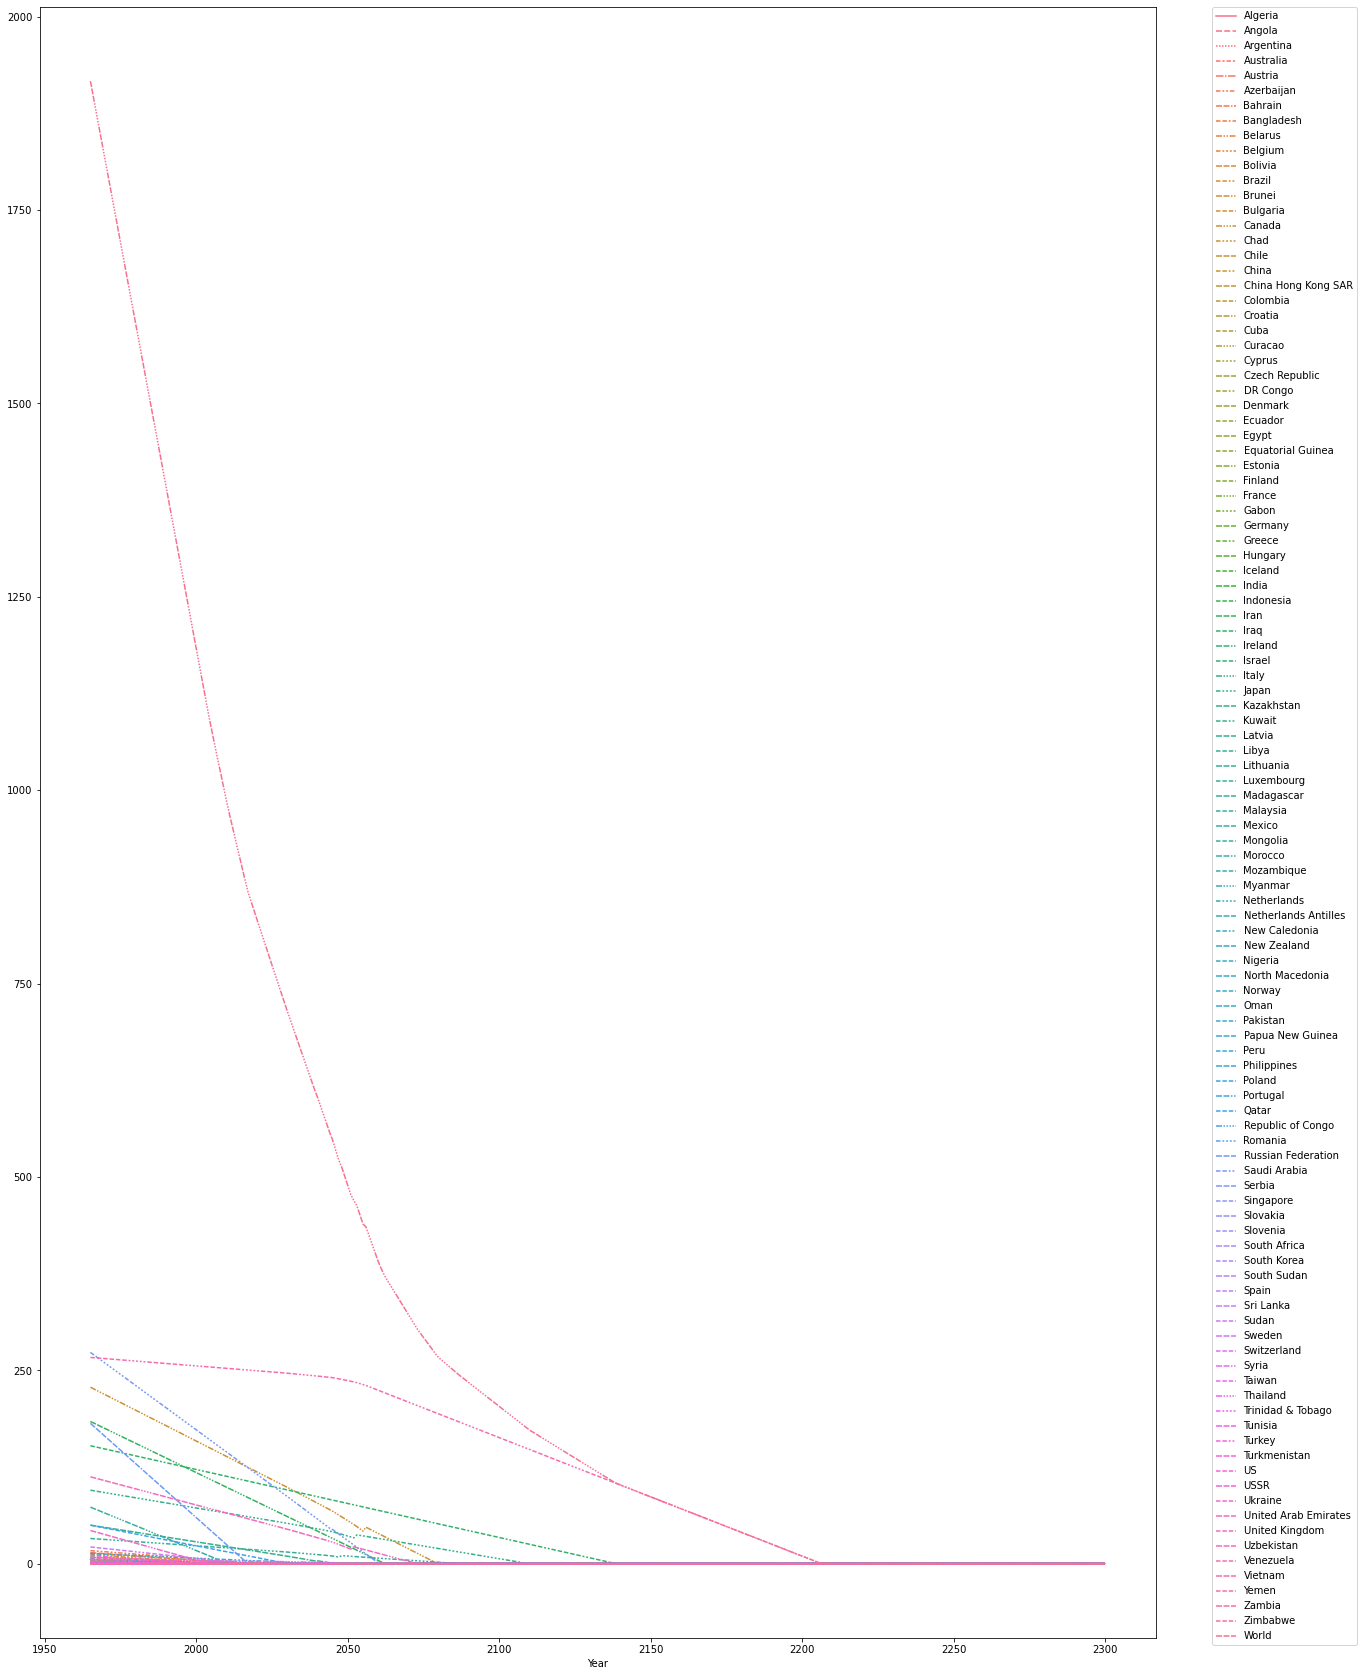

In [51]:
world_reserves(model_name = 'lasso')

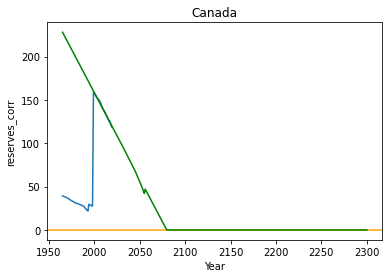

In [52]:
plot_reg('Canada', model_name = 'lasso')

lasso


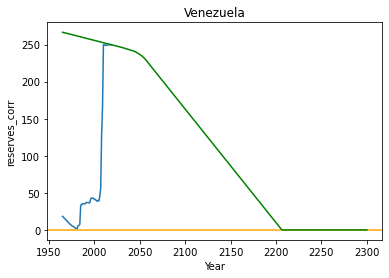

elasticnet


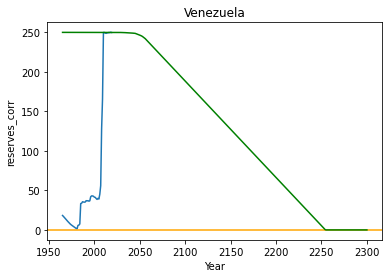

linearregression


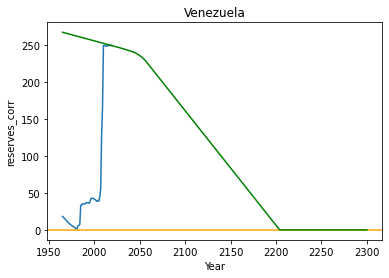

svr


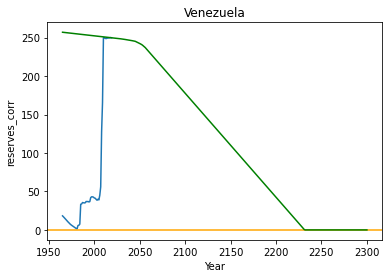

rbf


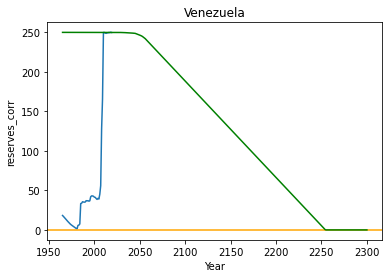

In [53]:
for i in models:
    print(i)
    plot_reg('Venezuela', model_name = i)

In [54]:
# last year of world reserves
end_of_reserves(model_name = 'lasso').max().end_year

2207

__Observation:__
Only the support vector regression with a polynomial kernel is able to make consistent rediction. The others have an inconsistent trend for venezuela because of the lack of data.

The confidence in the svr model with a poly kernel is therefore also low because we could not recreate the same trend with other approaches and we have made some hypothesis to capture the descending trend.

Now we proceed with searching for local shortage before the global world reserve shortage that could occur when a country is importing usually oil from a production country that now comes out of reserves.

To do so we will:
1. use a dataset that shows import / export between country to calculate the proportion of export from each producer to each consumer
2. plot offer vs demand for each country taking into account the predictions we just made
3. list all the country that are affected when the reserves of a producer comes to 0 and in which proportion of their demand
4. for each country correct the import porportion based on the remaining overall producer when the reserves of one are reducing (ex. lost of 10% of supply, the 0.8 and 0.1% remaining become 8/9 and 1/9)
5. take price evolution and isolate the shortage in history, recreate a bell curve shape of price increase based on shotage intensity
6. isolate the price trend
6. apply the shortage impact on price when shortage occur

__firt hypothesis, each conutries consumes the same distribution of supply according the the 2019 production proportion and the revised proportion at the year of the prediction: it implies that we need only the enod of reserves year for each country in the prediction and apply there a deformation of the price trend due to the offer/demand unbalance.__

In [55]:
# determining end of reserves by country for the predictions
pred = preds['lasso']
pred_reserves_end = pred.set_index('Year').idxmin().reset_index()
pred_reserves_end.columns =['Country','Year']

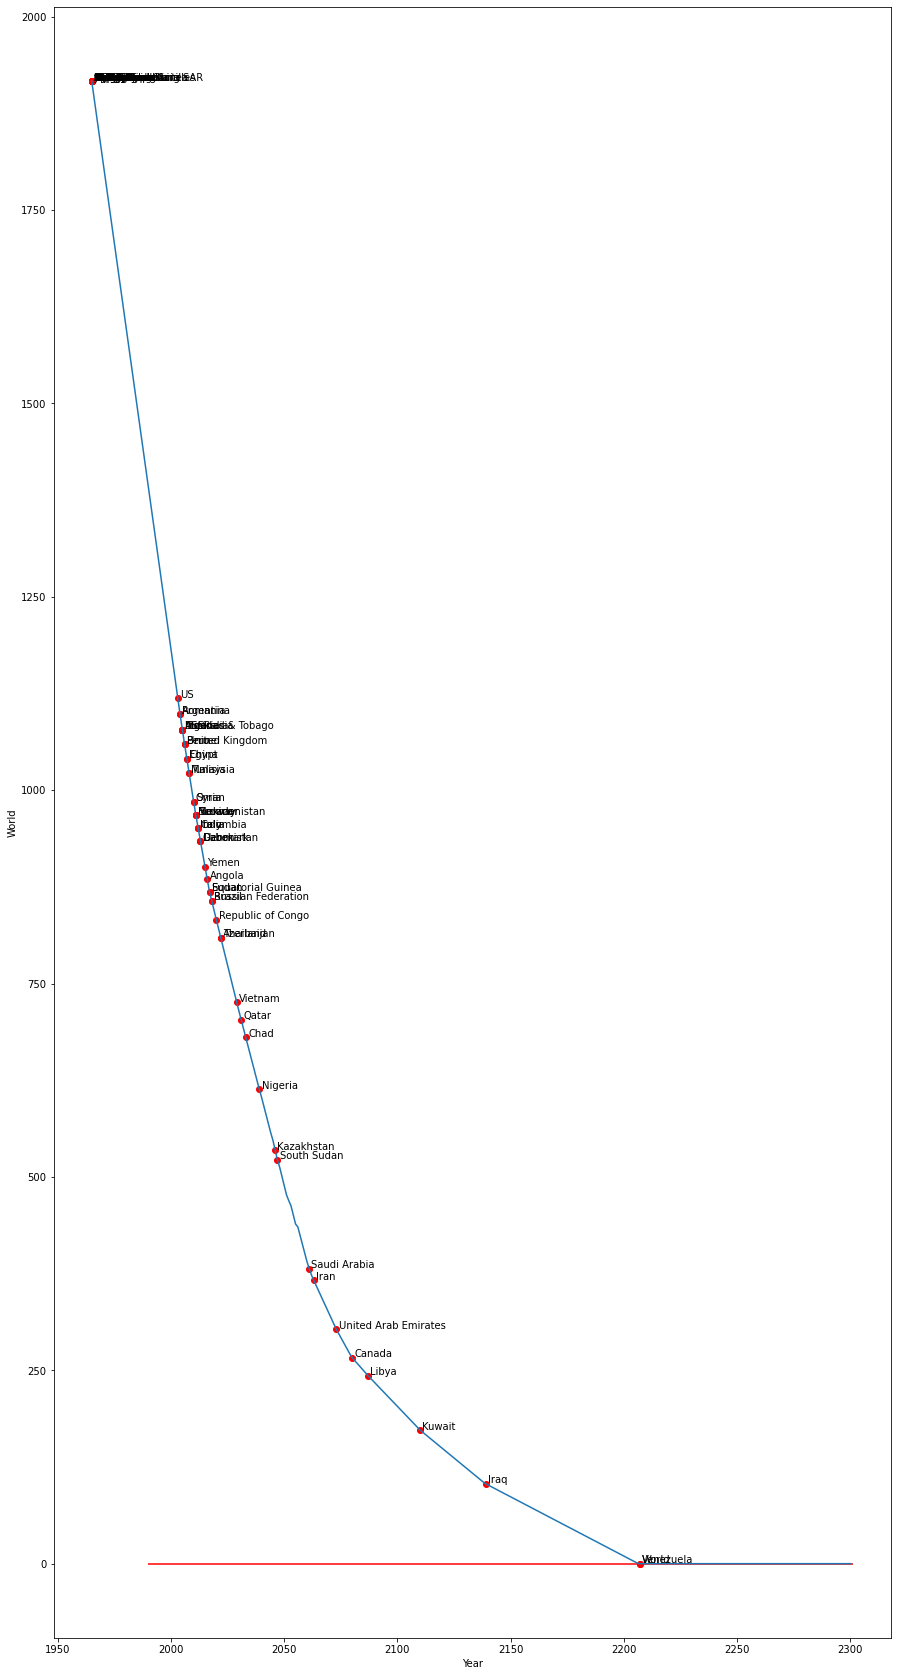

In [56]:
# world_reserves(model_name = 'svr')
# recreate series of point corrresponding to the world reserve at the moment a country comes out of reserve
shortage_world_reserves = pred_reserves_end.Year.apply(lambda x: pred[pred['Year'] == x].World.values[0])
plt.figure(figsize = (15,30))
sns.lineplot(x = 'Year', y='World', data = pred);
plt.scatter(x = pred_reserves_end.Year, y= shortage_world_reserves, color = 'red');
# plot country name next to each point
for i, txt in enumerate(pred_reserves_end.Country):
    plt.annotate(txt, (pred_reserves_end.Year[i]+1, shortage_world_reserves[i]+1));
plt.hlines(xmin = 1990, xmax = pred_end + 1 , y=0, color = 'red');

In [57]:
reserve_limit('World'), reserve_limit('World', 'svr'), reserve_limit('World', 'rbf')

(2207, nan, nan)

1980: supply shortcut in middle east
2008: North America shortcut in supply
2011 and 2008 are linked, we could only consider that due to the 2008 subprime crisis, there was a reduction in vestment and therefore in consumption so that it locally decreased the import of the shortage which was again visible when the massive investment plan started in 2011.

Choosing which price definition to use (money of the day or with inflation):

We choose the $2019 as index so that we have 2 comparable crisis to model the impact compared to production reduction and duration of this shortage.

In [58]:
#todo: add vis of all reduction in production and see if they have sometimes no effect to have discussion on the confidence around the price driver hypothesis made
# compare the price, production and GDP/investment curve. See if sometimes, the cashflow did not find the adequate production which led to the increase.

In [59]:
gdp = pd.read_csv('data/world_gdp.csv')
gdp.columns = ['Year', 'GDP', 'growth', 'Per Capita',
       'GDP Nominal', 'Pop change', 'World Population']
gdp.loc[:,'growth'] = gdp.growth.apply(lambda x: float(x.replace('%','')))
gdp.loc[:,'Per Capita'] = gdp['Per Capita'].apply(lambda x: float(x.replace('$','').replace(',','')))
gdp.loc[:,'GDP'] = gdp['GDP'].apply(lambda x: float(x.replace('$','').replace(',','')))
gdp.head()

,Year,GDP,growth,Per Capita,GDP Nominal,Pop change,World Population
0,2017,8.025011e+13,3.14,10632.0,"$80,934,771,028,340",1.12 %,"7,547,858,925"
1,2016,7.779677e+13,2.51,10423.0,"$76,146,112,644,153",1.14 %,"7,464,022,049"
2,2015,7.583419e+13,2.86,10276.0,"$75,037,186,502,550",1.16 %,"7,379,797,139"
3,2014,7.372538e+13,2.86,10106.0,"$79,319,858,280,899",1.17 %,"7,295,290,765"
4,2013,7.168793e+13,2.62,9942.0,"$77,218,621,016,248",1.19 %,"7,210,581,976"


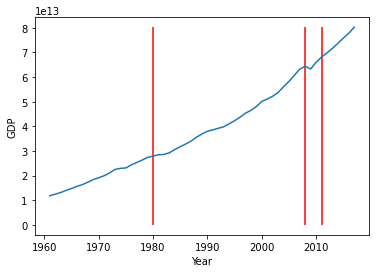

In [60]:
sns.lineplot(x = 'Year', y = 'GDP', data = gdp);
plt.vlines(x = 1980, ymin = 0, ymax = 8.025011e+13, color = 'red');
plt.vlines(x = 2008, ymin = 0, ymax = 8.025011e+13, color = 'red');
plt.vlines(x = 2011, ymin = 0, ymax = 8.025011e+13, color = 'red');

In [61]:
df.Region.unique()

array(['Africa', 'S. & Cent. America', 'Asia Pacific', 'Europe', 'CIS',
       'Middle East', 'North America', nan], dtype=object)

In [62]:
df.Country.unique()

array(['Algeria', 'Angola', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium',
       'Bolivia', 'Brazil', 'Brunei', 'Bulgaria', 'Canada', 'Chad',
       'Chile', 'China', 'China Hong Kong SAR', 'Colombia', 'Croatia',
       'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'DR Congo',
       'Denmark', 'Ecuador', 'Egypt', 'Equatorial Guinea', 'Estonia',
       'Finland', 'France', 'Gabon', 'Germany', 'Greece', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Latvia',
       'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malaysia',
       'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar',
       'Netherlands', 'Netherlands Antilles', 'New Caledonia',
       'New Zealand', 'Nigeria', 'North Macedonia', 'Norway', 'Oman',
       'Pakistan', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Republic of Congo',

In [86]:
pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma='auto'))

In [92]:
class price_model:
    
    pr = pd.read_csv('data/bp-stats-review-2020-all - Oil - Crude prices since 1861.csv')
    df = pd.DataFrame()
    drop = pd.DataFrame()
    pr_increase = pd.DataFrame()
    dr = pd.DataFrame()
    pr_reg = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,coef0=1)
    price = pd.DataFrame()
    pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma='auto'))
    shortage_dates = pd.Series()
    pred = pd.DataFrame()
    years_2100 = np.arange(1965,pred_end + 1 ,1)
    
    def __init__(self, reserves_data, reserves_preds):
        self.df = reserves_data.df
        # correction shape -  function calculates the impact of the price increase function of the distance to the shortage in year
        self.drop = self.df[(self.df['Country'] == 'Iran') & (self.df['Year']>=1978) & (self.df['Year']<= 1982)].set_index('Year').oilprod_yearlybbl
        self.pr_increase = self.pr[(self.pr['Year']>=1978) & (self.pr['Year']<=1982)]['$ money of the day']
        self.dr.loc[:,'year']= self.drop.index
        self.dr.loc[:,'production']= self.drop.values
        self.dr.loc[:,'price'] = self.pr_increase.values
        self.dr.loc[self.dr['year']>self.dr.year.min(),'production_change'] = self.dr[self.dr['year']>self.dr.year.min()].year.apply(lambda x : (self.dr[self.dr['year'] == (x)].production.values[0] - self.dr[self.dr['year'] == x-1].production.values[0]))
        self.dr.loc[self.dr['year']>self.dr.year.min(),'price_change'] = self.dr[self.dr['year']>self.dr.year.min()].year.apply(lambda x : (self.dr[self.dr['year'] == (x)].price.values[0] - self.dr[self.dr['year'] == x-1].price.values[0]))
        self.dr.loc[:,'price_on_prod'] = self.dr['price_change']/(-1*self.dr['production_change'])
        self.pr_reg.fit(np.array(self.dr['production_change'].dropna()).reshape(-1,1),self.dr['price_change'].dropna())      
        self.price = self.pr[self.pr['Year']>=1960]
        self.baseline_reg()
        self.shortage_dates = reserves_preds.preds['lasso'].set_index('Year').idxmin()
        self.pred = reserves_preds.preds['lasso']
        
    def plot_price_historics(self):
        # loading and plotting historical price data
        fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (15,25))
        sns.lineplot(x = 'Year', y = '$ 2019', data = self.pr, ax = ax1);
        sns.lineplot(x = 'Year', y = '$ money of the day', data = self.pr, color = 'orange', ax = ax1);
        for i in ['Iran']:
            sns.lineplot(data = df.query('Country == @i'), x = 'Year', y= 'oilprod_yearlybbl', ax = ax2, label = i);
        ax1.vlines(x = 1978, ymin = 0, ymax = 125, color = 'green')
        ax1.vlines(x = 1980, ymin = 0, ymax = 125, color = 'red')
        ax1.vlines(x = 1985, ymin = 0, ymax = 125, color = 'green')
        # ax1.vlines(x = 1986, ymin = 0, ymax = 125, color = 'red')
        ax2.vlines(x = 1978, ymin = 0, ymax = 5, color = 'green')
        ax2.vlines(x = 1980, ymin = 0, ymax = 5, color = 'red')
        ax2.vlines(x = 1985, ymin = 0, ymax = 5, color = 'green')
        # ax2.vlines(x = 1986, ymin = 0, ymax = 5, color = 'red')
        plt.xlim(1965,2020);

    
    def plot_price_vs_prod_change(self):
        sns.lineplot(x = 'production_change', y = 'price_change', data = self.dr);
        plt.scatter(x = np.arange(-1,0.5,.1),y = self.pr_reg.predict(np.arange(-1,0.5,.1).reshape(-1, 1)), color = 'orange');
        plt.show()

    def price_correction(self, prod):
        corr = self.pr_reg.predict(prod.reshape(-1,1))
        return corr

    def baseline_reg(self):
        """
        Fit and plot price baseline
        """
        future = np.array(list(range(2019,2100,1))).reshape(-1, 1)
        lw = 2
        X = self.price['Year'].values.reshape(-1,1)
        y = self.price['$ money of the day'].values
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
        axes.plot(X, self.pipe.fit(X, y).predict(X), color='blue', lw=lw,
                      label='{} model'.format('Polynomial'))
        axes.scatter(X[self.pipe[1].support_], y[self.pipe[1].support_], facecolor="none",
                         edgecolor='blue', s=50,
                         label='{} support vectors'.format('Polynomial'))
        axes.scatter(X[np.setdiff1d(np.arange(len(X)), self.pipe[1].support_)],
                         y[np.setdiff1d(np.arange(len(X)), model.support_)],
                         facecolor="none", edgecolor="k", s=50,
                         label='other training data')
        sns.lineplot(x = future.reshape(1, -1)[0] , y = self.pipe.predict(future).reshape(1, -1)[0], alpha = .5, dashes=[(2, 2)], style = True, color = 'orange')
        axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)
        fig.text(0.5, 0.04, 'data', ha='center', va='center')
        fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
        fig.suptitle("Support Vector Regression", fontsize=14)
        plt.show()

    # we decide to impact shortage overs 5 years as Iran crisis and it seems consistent. year 1 to 3 we consider the drop in production, while year 4 and 5 are equal in drop to 1 and 2 - logistic recovery time rest is 0 price impact
    def shortage_impact(self, Country):
        country = Country
        shortage_year = self.shortage_dates.loc[country] 
        if shortage_year>2020:
            rg = 3
            hist = self.pred[['Year',country]]
    #         hist = pred[(pred['Year'] >= shortage_year - rg) & (pred['Year'] <= shortage_year + rg)][['Year',country]]
            hist.loc[:,'production_drop'] = hist[(hist['Year'] >= shortage_year - rg+1) & (hist['Year'] <= shortage_year)].Year.apply(lambda x:hist.loc[hist['Year'] == x][country].values[0] - hist.loc[hist['Year'] == x-1][country].values[0])
            hist.loc[:,'production_drop_cum'] = hist.production_drop.cumsum()
            hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'price_change'] = price_correction(hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'production_drop_cum'].values)
            hist.loc[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg),'price_change'] = hist[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg)].Year.apply(lambda x: hist[hist['Year'] == shortage_year - (hist.loc[hist['Year'] == x,'Year'].values[0] - shortage_year)]['price_change'].values[0])
    #         hist.loc[(hist['Year']>shortage_year + rg) & (hist['Year']<shortage_year - rg)] = 0
            hist = hist.fillna(0)
    #         correction = hist.price_change.values
        else:
            hist = self.pred[['Year',country]]
            hist.loc[:,'price_change'] = 0
        return hist.price_change

    def predict_price(self, years):
        base_price = self.price_reg.predict(years.reshape(-1, 1))
        price_corrections = np.zeros(len(years))
        for c in self.df.Country.unique():
            price_corrections += shortage_impact(c)
        final_price = base_price + price_corrections
        return final_price

    def plot_price_preds(self):
        sns.lineplot(x = self.years_2100, y = self.predict_price(self.years_2100));
        plt.ylim(0,350);
        plt.xlim(2020,2080);
        plt.xlabel('year');
        plt.ylabel('crude oil price');
        plt.title('Crude oil price predictions');
        plt.show()

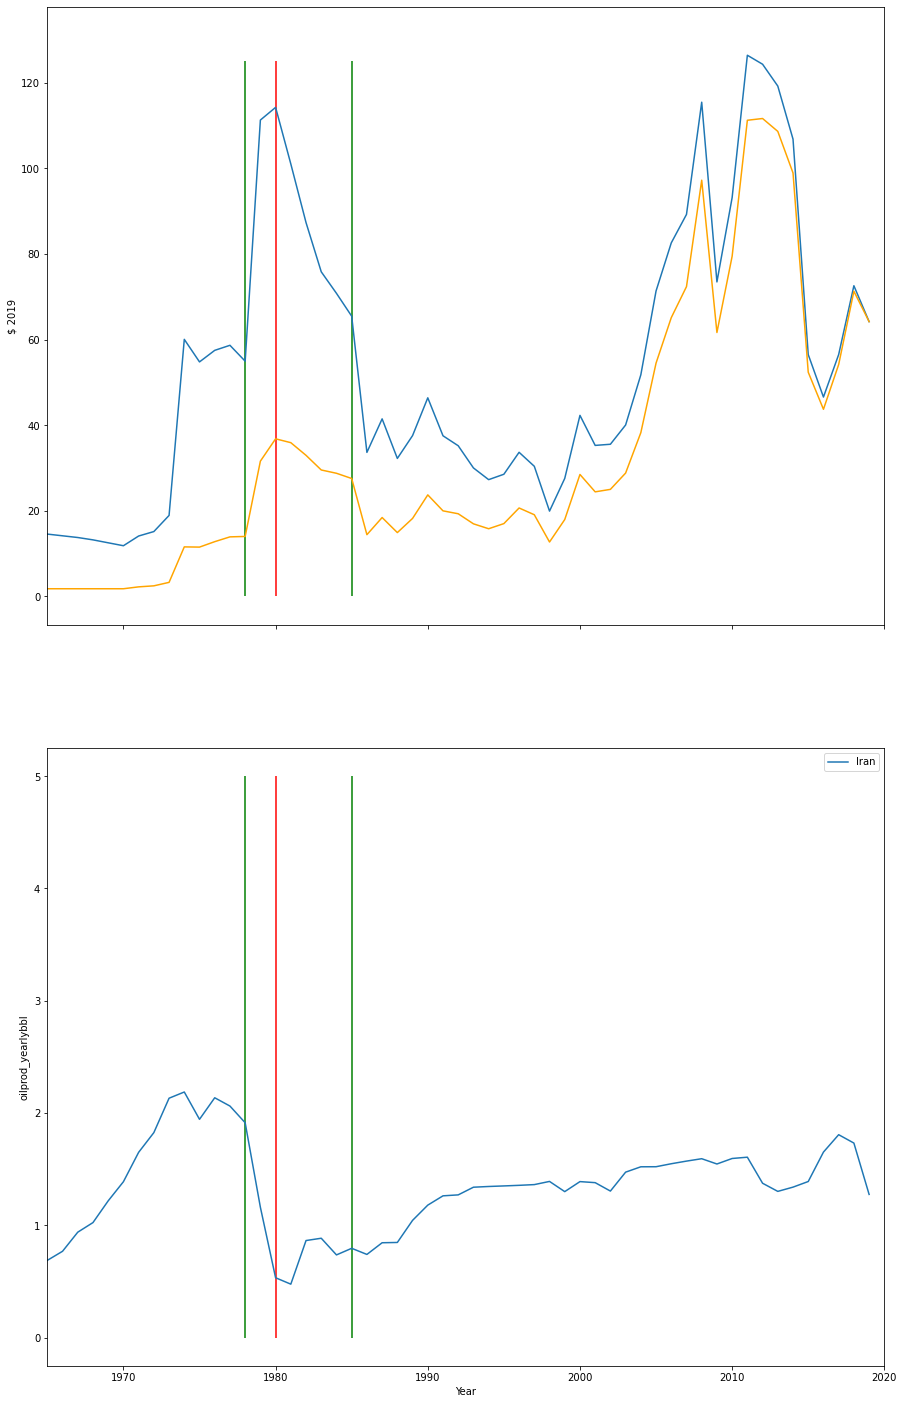

In [64]:
# loading and plotting data

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (15,25))
pr = pd.read_csv('data/bp-stats-review-2020-all - Oil - Crude prices since 1861.csv')
sns.lineplot(x = 'Year', y = '$ 2019', data = pr, ax = ax1);
sns.lineplot(x = 'Year', y = '$ money of the day', data = pr, color = 'orange', ax = ax1);
# sns.lineplot(data = data, x = 'Year', y= 'oilprod_yearlybbl', label = 'production',ax = ax3);
# sns.lineplot(data = data, x = 'Year', y= 'oilcons_yearlybbl', label = 'consumption', ax = ax3);
# sns.lineplot(x = 'Year', y = 'growth', data = gdp, label = 'growth', ax = ax4);
# sns.lineplot(data = data, x = 'Year', y= 'oilprod_yearlybbl', color = 'green', ax = ax2);
# ['Africa', 'S. & Cent. America', 'Asia Pacific', 'Europe', 'CIS','Middle East', 'North America']
# sns.lineplot(data = df.query('Region == "Middle East"'), x = 'Year', y= 'oilprod_yearlybbl', ax = ax2, label = i);
for i in ['Iran']:
    sns.lineplot(data = df.query('Country == @i'), x = 'Year', y= 'oilprod_yearlybbl', ax = ax2, label = i);
ax1.vlines(x = 1978, ymin = 0, ymax = 125, color = 'green')
ax1.vlines(x = 1980, ymin = 0, ymax = 125, color = 'red')
ax1.vlines(x = 1985, ymin = 0, ymax = 125, color = 'green')
# ax1.vlines(x = 1986, ymin = 0, ymax = 125, color = 'red')
ax2.vlines(x = 1978, ymin = 0, ymax = 5, color = 'green')
ax2.vlines(x = 1980, ymin = 0, ymax = 5, color = 'red')
ax2.vlines(x = 1985, ymin = 0, ymax = 5, color = 'green')
# ax2.vlines(x = 1986, ymin = 0, ymax = 5, color = 'red')
plt.xlim(1965,2020);

In [65]:
# correction shape -  function calculates the impact of the price increase function of the distance to the shortage in year
drop = df[(df['Country'] == 'Iran') & (df['Year']>=1978) & (df['Year']<= 1982)].set_index('Year').oilprod_yearlybbl
pr_increase = pr[(pr['Year']>=1978) & (pr['Year']<=1982)]['$ money of the day']
dr = pd.DataFrame()
dr.loc[:,'year']= drop.index
dr.loc[:,'production']= drop.values
dr.loc[:,'price'] = pr_increase.values
dr.loc[dr['year']>dr.year.min(),'production_change'] = dr[dr['year']>dr.year.min()].year.apply(lambda x : (dr[dr['year'] == (x)].production.values[0] - dr[dr['year'] == x-1].production.values[0]))
dr.loc[dr['year']>dr.year.min(),'price_change'] = dr[dr['year']>dr.year.min()].year.apply(lambda x : (dr[dr['year'] == (x)].price.values[0] - dr[dr['year'] == x-1].price.values[0]))
dr.loc[:,'price_on_prod'] = dr['price_change']/(-1*dr['production_change'])
dr

,year,production,price,production_change,price_change,price_on_prod
0,1978,1.914042,14.02,NaN,NaN,NaN
1,1979,1.161550,31.61,-0.752492,17.59,23.375660
2,1980,0.533905,36.83,-0.627644,5.22,8.316811
3,1981,0.476892,35.93,-0.057013,-0.90,-15.785897
4,1982,0.865290,32.97,0.388397,-2.96,7.621060


In [66]:
pr_reg = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,coef0=1)
pr_reg.fit(np.array(dr['production_change'].dropna()).reshape(-1,1),dr['price_change'].dropna())

SVR(C=100, coef0=1, degree=2, gamma='auto', kernel='poly')

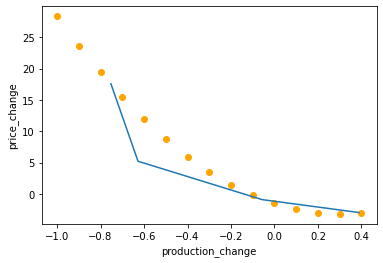

In [67]:
sns.lineplot(x = 'production_change', y = 'price_change', data = dr);
plt.scatter(x = np.arange(-1,0.5,.1),y = pr_reg.predict(np.arange(-1,0.5,.1).reshape(-1, 1)), color = 'orange');

In [68]:
def price_correction(prod):
    corr = pr_reg.predict(prod.reshape(-1,1))
    return corr

In [69]:
price = pd.read_csv('data/bp-stats-review-2020-all - Oil - Crude prices since 1861.csv')

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score

In [71]:
price = price[price['Year']>=1960]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(price[['Year']], price['$ money of the day'], test_size = .2)
reg = LinearRegression()
reg.fit(X_train, y_train.values.reshape(-1, 1))
y_pred = reg.predict(X_test)
r2_score(y_test, y_pred)

0.45866885540177194

In [73]:
from sklearn.svm import SVR

In [74]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')

In [75]:
# #############################################################################
# Generate sample data
X = price['Year'].values.reshape(-1,1)
y = price['$ money of the day'].values

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [76]:
future = np.array(list(range(2019,2100,1))).reshape(-1, 1)
lw = 2

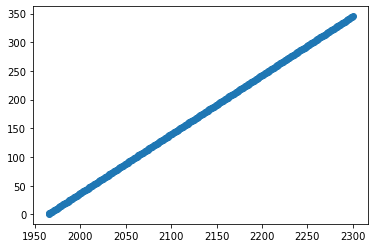

In [77]:
price_reg = make_pipeline(StandardScaler(),SVR(kernel = 'linear', C=100, gamma = 'auto'))
price_reg.fit(price['Year'].values.reshape(-1,1),price['$ money of the day'].values)
price_pred = price_reg.predict(years_2100.reshape(-1, 1))
plt.scatter(x = years_2100,y = price_pred);

In [78]:
def sv_reg(model):
    X = price['Year'].values.reshape(-1,1)
    y = price['$ money of the day'].values
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
    pipe = make_pipeline(StandardScaler(), model)
    axes.plot(X, pipe.fit(X, y).predict(X), color='blue', lw=lw,
                  label='{} model'.format('Polynomial'))
    axes.scatter(X[model.support_], y[model.support_], facecolor="none",
                     edgecolor='blue', s=50,
                     label='{} support vectors'.format('Polynomial'))
    axes.scatter(X[np.setdiff1d(np.arange(len(X)), model.support_)],
                     y[np.setdiff1d(np.arange(len(X)), model.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    sns.lineplot(x = future.reshape(1, -1)[0] , y = pipe.predict(future).reshape(1, -1)[0], alpha = .5, dashes=[(2, 2)], style = True, color = 'orange')
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)
    fig.text(0.5, 0.04, 'data', ha='center', va='center')
    fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
    fig.suptitle("Support Vector Regression", fontsize=14)
    plt.show()

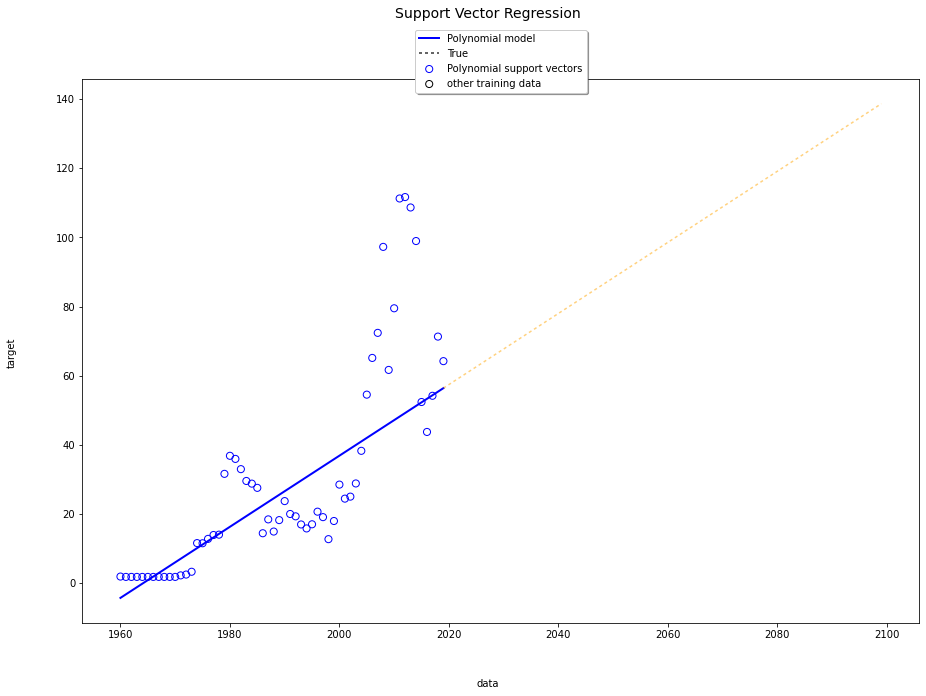

In [79]:
sv_reg(svr_lin)

In [80]:
shortage_dates = pred.set_index('Year').idxmin()
country = 'Kazakhstan'
shortage_year = shortage_dates.loc[country]
rg = 3
hist = pred[(pred['Year'] >= shortage_year - rg) & (pred['Year'] <= shortage_year + rg)][['Year',country]]
hist.loc[:,'production_drop'] = hist[(hist['Year'] >= shortage_year - rg+1) & (hist['Year'] <= shortage_year)].Year.apply(lambda x:hist.loc[hist['Year'] == x][country].values[0] - hist.loc[hist['Year'] == x-1][country].values[0])
hist.loc[:,'production_drop_cum'] = hist.production_drop.cumsum()
hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'price_change'] = price_correction(hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'production_drop_cum'].values)
hist.loc[(hist['Year']>shortage_year),'price_change'] = hist[hist['Year']>shortage_year].Year.apply(lambda x: hist[hist['Year'] == shortage_year - (hist.loc[hist['Year'] == x,'Year'].values[0] - shortage_year)]['price_change'].values[0])
hist = hist.fillna(0)
hist.price_change.values

array([ 0.        , 12.47096531, 40.55082025, 78.80754037, 40.55082025,
       12.47096531,  0.        ])

In [81]:
# we decide to impact shortage overs 5 years as Iran crisis and it seems consistent. year 1 to 3 we consider the drop in production, while year 4 and 5 are equal in drop to 1 and 2 - logistic recovery time rest is 0 price impact
def shortage_impact(Country):
    shortage_dates = pred.set_index('Year').idxmin()
    country = Country
    shortage_year = shortage_dates.loc[country] 
    if shortage_year>2020:
        rg = 3
        hist = pred[['Year',country]]
#         hist = pred[(pred['Year'] >= shortage_year - rg) & (pred['Year'] <= shortage_year + rg)][['Year',country]]
        hist.loc[:,'production_drop'] = hist[(hist['Year'] >= shortage_year - rg+1) & (hist['Year'] <= shortage_year)].Year.apply(lambda x:hist.loc[hist['Year'] == x][country].values[0] - hist.loc[hist['Year'] == x-1][country].values[0])
        hist.loc[:,'production_drop_cum'] = hist.production_drop.cumsum()
        hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'price_change'] = price_correction(hist.loc[hist['Year'].isin(range(shortage_year-rg+1,shortage_year+1,1)),'production_drop_cum'].values)
        hist.loc[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg),'price_change'] = hist[(hist['Year']>shortage_year) & (hist['Year']<shortage_year+rg)].Year.apply(lambda x: hist[hist['Year'] == shortage_year - (hist.loc[hist['Year'] == x,'Year'].values[0] - shortage_year)]['price_change'].values[0])
#         hist.loc[(hist['Year']>shortage_year + rg) & (hist['Year']<shortage_year - rg)] = 0
        hist = hist.fillna(0)
#         correction = hist.price_change.values
    else:
        hist = pred[['Year',country]]
        hist.loc[:,'price_change'] = 0
    return hist.price_change 

In [83]:
def predict_price(years):
    base_price = price_reg.predict(years.reshape(-1, 1))
    shortage_dates = pred.set_index('Year').idxmin()
    price_corrections = np.zeros(len(years))
    for c in df.Country.unique():
        price_corrections += shortage_impact(c)
    final_price = base_price + price_corrections
    return final_price

In [84]:
shortage_dates = pred.set_index('Year').idxmin()

In [90]:
type(shortage_dates)

pandas.core.series.Series

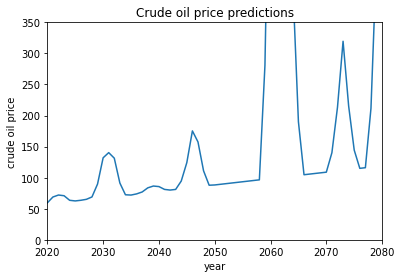

In [85]:
sns.lineplot(x = years_2100, y = predict_price(years_2100));
plt.ylim(0,350)
plt.xlim(2020,2080)
plt.xlabel('year');
plt.ylabel('crude oil price');
plt.title('Crude oil price predictions');

# TODO

- [ ] ajouter pour chaque pays en tant que producteur, la part de crude oil destiné à chaque autre pays (hypothèse naive, la proportion d'export vers chaque pays reste la même tant que le pays a des stocks puis elle se répartie équitablement vers chaque autre producteur de la région).
- [ ] consolider les réserves par organisation exportatices de pétroles et zones géographiques
- [ ] add pipelines folowing this article: https://medium.com/@kadirmalak/how-to-pipe-chain-functions-in-python-137c36150c1

Regarder Major trade movements 2020 (million tonnes) sur https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/oil.html#oil-production pour anticiper les échanges actuelles de barils et comment cela impactera la consommation des réserves sur le tas (faire par proportion)